LINK => [LDA](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#:~:text=The%20most%20important%20tuning%20parameter,be%20%3E%201)

### Preprocessing
Stop-word elimination: removal of the most common words in a language that are not helpful and in general unusable in text mining like prepositions, numbers, and words that do not contain applicable information for the study. In fact, in NLP, there is no particular general list of stop words used by all developers who choose their list based on their goal to improve the recommendation system performance.

• Stemming: the conversion of words into their root, using stemming algorithms such as Snowball Stemmer.

• Lemmatizing: used to enhance the system's accuracy by returning the base or dictionary form of a word.

• Tokenizing: dividing a text input into tokens like phrases, words, or other meaningful elements (tokens). The outcome of tokenization is a sequence of tokens.

• Identifying n-gram procedure such as bigram (phrases containing two words) and trigram (phrases containing three words) words and consider them as one word.

After the preprocessing step, we applied a commonly used term-weighting method called TF-IDF, which is a pre-filtering stage with all the included TM methods. TF-IDF is a numerical statistic measure used to score the importance of a word (term) 

## Description of Assumptions 

- Documents with similar topics will use similar group of words
- Document Definition/Modeling
  - Documents are probability distribution over latent topic
  - Topics are probability distribution over words

LDA takes a number of documents. It assumes that the words are in each document are related. It then tries to figure out the "recipe" for how each document could have been created. We just need to tell the model how many topics to construct and it uses that "recipe" to generate topic and word distributions over a corpus. Based on that output, we can identify similar documents within the corpus.


**Advantages**
 - LDA is an effective tool for topic modeling.
 - Easy to understand conceptually
 - Has been shown to produce good results over many domains.
 - New application

**Limitations**

-  Must know the number of topics K in advance
- Dirichlet topic distribution cannot capture correlations among topics


### Hyperparameter Tuning in LDA
First, let’s differentiate between model hyperparameters and model parameters :

__Model hyperparameters__ can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

__Model parameters__ can be thought of as what the model learns during training, such as the weights for each word in a given topic
Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

1. Number of Topics (K)
1. Dirichlet hyperparameter alpha: Document-Topic Density
1. Dirichlet hyperparameter beta: Word-Topic Density

## Load the packages

In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=787e023f9cc04d34a1dddab0aeef9be436497b6bbb9154db20ce668d00441052
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=d6605e5ec4be4307ccadb7deeb5bc0647fb00d57bd7008bb90dd04ce5ef530f6
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [2]:
!python3 -m spacy download en

2022-10-09 10:34:53.301247: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 8.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Import Newsgroups Text Data

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [5]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


## Remove emails and newline characters

In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-6-10af9153bd18>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-6-10af9153bd18>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## Tokenize and Clean-up using gensim’s simple_preprocess()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Lemmatization

In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['s thing subject car nntp post host college park line wonder out there enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know tellme model name engine spec year production car make history info funky look car mail thank bring neighborhood lerxst', 'subject clock poll final call summary final call clock report keyword acceleration clock upgrade article line nntp post host fair number brave soul upgrade clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request summarize next day so add network knowledge base do clock upgrade answer poll thank']


In [9]:
data_lemmatized[:2]

['s thing subject car nntp post host college park line wonder out there enlighten car see other day door sport car look late early call door really small addition front bumper separate rest body know tellme model name engine spec year production car make history info funky look car mail thank bring neighborhood lerxst',
 'subject clock poll final call summary final call clock report keyword acceleration clock upgrade article line nntp post host fair number brave soul upgrade clock oscillator share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy especially request summarize next day so add network knowledge base do clock upgrade answer poll thank']

## Create the Document-Word matrix

In [10]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [14]:
data_vectorized[0]

<1x7758 sparse matrix of type '<class 'numpy.int64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [16]:
data_vectorized

<11314x7758 sparse matrix of type '<class 'numpy.int64'>'
	with 725001 stored elements in Compressed Sparse Row format>

## Check the Sparsity

In [16]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.8259859421715849 %


## Build LDA model with sklearn

In [17]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


#### Output of above code

```python
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
```

## Diagnose model performance with perplexity and log-likelihood

In [18]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -8153640.003229906
Perplexity:  1721.0030040794254
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## How to GridSearch the best LDA model?

The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [19]:
# Define Search Param
search_params = {'n_components': [10, 15], 'learning_decay': [.5, .7, .9]}
# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15]})

#### Output of above cell

```python
GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                                                 verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
```

#### Output of the above cell

```python
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
```

## How to see the best topic model and its parameters?

In [43]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1716905.333006981
Model Perplexity:  1634.4105549629749


In [21]:
model.best_score_

-1718429.7833504635

## Compare LDA Model Performance Scores

Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.

This makes me think, even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.

To tune this even further, you can do a finer grid search for number of topics between 10 and 15. But I am going to skip that for now.

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. I don’t know that yet. But LDA says so. Let’s see.

In [21]:
model.cv_results_

{'mean_fit_time': array([61.39949212, 69.95949049, 57.9276926 , 68.71314883, 58.14784265,
        69.05288577]),
 'std_fit_time': array([1.83267104, 0.87199798, 1.21805866, 1.1683667 , 0.97291713,
        1.08234171]),
 'mean_score_time': array([1.3087358 , 1.48202858, 1.21872535, 1.44072952, 1.16675825,
        1.45148206]),
 'std_score_time': array([0.23783674, 0.05338105, 0.06318352, 0.08473002, 0.05505869,
        0.08156289]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.7, 0.7, 0.9, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_components': masked_array(data=[10, 15, 10, 15, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_decay': 0.5, 'n_components': 10},
  {'learning_decay': 0.5, 'n_components': 15},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components':

In [22]:
grid_cv_model_result = pd.DataFrame(model.cv_results_)

In [42]:
grid_cv_model_result.columns
grid_cv_model_result["mean_test_score"]

0   -1.719942e+06
1   -1.740082e+06
2   -1.718430e+06
3   -1.739872e+06
4   -1.721759e+06
5   -1.740266e+06
Name: mean_test_score, dtype: float64

In [31]:
grid_cv_model_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,61.399492,1.832671,1.308736,0.237837,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-1.664810e+06,-1.818943e+06,-1.744809e+06,-1.705403e+06,-1.676568e+06,-1.722107e+06,55728.610696,3
1,69.959490,0.871998,1.482029,0.053381,0.5,15,"{'learning_decay': 0.5, 'n_components': 15}",-1.681811e+06,-1.840141e+06,-1.763882e+06,-1.724495e+06,-1.695922e+06,-1.741250e+06,56850.796017,6
2,57.927693,1.218059,1.218725,0.063184,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-1.657074e+06,-1.818574e+06,-1.740083e+06,-1.697398e+06,-1.672843e+06,-1.717194e+06,57922.463905,2
3,68.713149,1.168367,1.440730,0.084730,0.7,15,"{'learning_decay': 0.7, 'n_components': 15}",-1.682231e+06,-1.835345e+06,-1.764762e+06,-1.724607e+06,-1.696478e+06,-1.740685e+06,55081.447682,5
4,58.147843,0.972917,1.166758,0.055059,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-1.656369e+06,-1.813970e+06,-1.739646e+06,-1.701846e+06,-1.672694e+06,-1.716905e+06,56186.649386,1
5,69.052886,1.082342,1.451482,0.081563,0.9,15,"{'learning_decay': 0.9, 'n_components': 15}",-1.686229e+06,-1.837119e+06,-1.758097e+06,-1.720697e+06,-1.695845e+06,-1.739597e+06,54721.967069,4


In [47]:
model.score(data_vectorized)

-8097144.088790147

In [37]:
# log_likelyhoods_5 = grid_cv_model_result[grid_cv_model_result['param_learning_decay'] == 0.5]["mean_test_score"].values
# log_likelyhoods_7 = grid_cv_model_result[grid_cv_model_result['param_learning_decay'] == 0.7]["mean_test_score"].values
# log_likelyhoods_9 = grid_cv_model_result[grid_cv_model_result['param_learning_decay'] == 0.9]["mean_test_score"].values

In [39]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
# log_likelyhoods_5 = [round(gscore.mean_test_score) for gscore in grid_cv_model_result if gscore[gscore['learning_decay']==0.5]]
# log_likelyhoods_7 = [round(gscore.mean_test_score) for gscore in grid_cv_model_result if gscore[gscore['learning_decay']==0.7]]
# log_likelyhoods_9 = [round(gscore.mean_test_score) for gscore in grid_cv_model_result if gscore[gscore['learning_decay']==0.9]]

# Show graph
# plt.figure(figsize=(12, 8))
# plt.plot(n_topics, log_likelyhoods_5, label='0.5')
# plt.plot(n_topics, log_likelyhoods_7, label='0.7')
# plt.plot(n_topics, log_likelyhoods_9, label='0.9')
# plt.title("Choosing Optimal LDA Model")
# plt.xlabel("Num Topics")
# plt.ylabel("Log Likelyhood Scores")
# plt.legend(title='Learning decay', loc='best')
# plt.show()

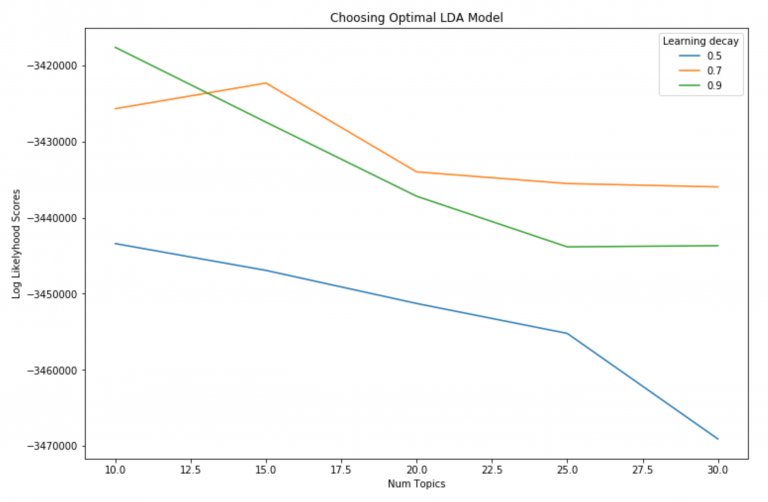

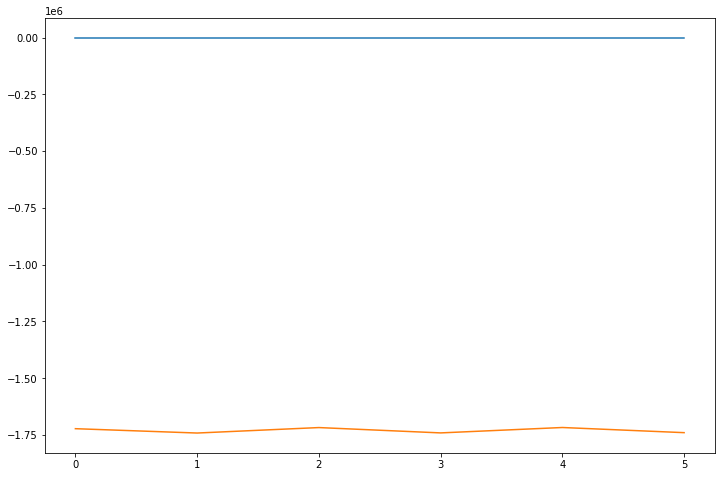

In [40]:
plt.figure(figsize=(12,8))
plt.plot(grid_cv_model_result.loc[:, ["param_learning_decay", "mean_test_score"]])

## How to see the dominant topic in each document?

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.



In [50]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.740000,0.000000,0.240000,0.000000,0.000000,0.000000,0.000000,3
Doc1,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.780000,0.000000,0.000000,7
Doc2,0.000000,0.000000,0.000000,0.330000,0.000000,0.080000,0.000000,0.450000,0.000000,0.130000,7
Doc3,0.000000,0.000000,0.000000,0.630000,0.000000,0.000000,0.000000,0.340000,0.000000,0.000000,3
Doc4,0.030000,0.000000,0.000000,0.180000,0.000000,0.000000,0.280000,0.210000,0.080000,0.210000,6
Doc5,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
Doc6,0.000000,0.000000,0.000000,0.640000,0.100000,0.000000,0.240000,0.000000,0.000000,0.000000,3
Doc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140000,0.820000,0.000000,0.040000,7
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.950000,0.010000,0.010000,0.010000,6
Doc9,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.320000,0.560000,0.000000,0.000000,7


## Review topics distribution across documents

In [51]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,2120
1,3,2002
2,6,1427
3,9,1371
4,2,1101
5,0,1044
6,5,874
7,8,728
8,4,404
9,1,243


## How to visualize the LDA model with pyLDAvis?

In [52]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  15.347645
6       0.648955  71.707100       2        1  13.934217
2      71.019684   9.971006       3        1  13.141398
7       3.785981  33.185135       4        1  11.389348
3     -42.666500  -9.222070       5        1   9.521432
8      -3.621689 -43.526516       6        1   8.978754
5      -3.632402  -4.171708       7        1   8.847190
0     -36.584400  35.804413       8        1   7.612560
1      44.391380  50.615383       9        1   6.013196
4      40.235809 -31.591665      10        1   5.214259, topic_info=              Term         Freq        Total Category  logprob  loglift
2656          file  2963.000000  2963.000000  Default  30.0000  30.0000
3789           key  2189.000000  2189.000000  Default  29.0000  29.0000
2875          game  1915.000000  1915.000000  Default  28.0000  28.0000
6911          team  1504.000000  1504.000000  Default  27.0000  27.0000
7636        window  2587.000000  2587.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4812  organization   237.415665  5220.877501  Topic10  -5.4821  -0.1368
1017          case   212.097670  1918.274514  Topic10  -5.5949   0.7516
5235          post   217.614245  7021.601737  Topic10  -5.5692  -0.5202
6064           say   216.575530  7045.370912  Topic10  -5.5740  -0.5284
3819          know   210.702275  6540.993234  Topic10  -5.6015  -0.4816

[814 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
16        1  0.872923  absolute
16        2  0.010392  absolute
16        3  0.055424  absolute
16        6  0.010392  absolute
16        7  0.041568  absolute
...     ...       ...       ...
7737      9  0.081346      year
7737     10  0.097008      year
7739     10  0.988773     yeast
7754      3  0.960496   zionist
7754      9  0.026680   zionist

[2479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 3, 8, 4, 9, 6, 1, 2, 5])

## How to see the Topic’s keywords?

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [53]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,aaron,abandon,abbreviation,aberystwyth,abide,ability,able,abolish,abomination,...,yourselfer,youth,yup,yzerman,zinc,zionism,zionist,zip,zone,zoom
Topic0,57.051609,0.100046,3.223693,0.100100,0.100001,0.100000,33.498329,62.341894,0.100001,2.204474,...,0.100001,3.226543,0.100084,20.099990,0.100008,0.100000,0.100000,1.374530,72.055073,0.100056
Topic1,0.100001,0.100000,9.976625,0.100001,0.100003,0.100009,4.897273,53.132415,0.100011,4.153215,...,0.100000,15.939480,0.100006,0.100000,0.100004,0.100018,1.708177,0.100003,0.100026,0.100003
Topic2,0.100009,12.761906,15.108977,0.100001,0.100000,63.949699,10.587005,115.923233,17.834819,9.464478,...,0.100011,25.006045,0.100001,0.100001,0.100000,50.736676,72.491805,6.583413,74.045245,0.100007
Topic3,0.100005,0.100011,0.100014,6.427529,13.099962,0.100007,0.975012,82.757415,0.100007,0.100348,...,4.859251,0.100017,0.100070,0.100003,0.100015,16.463300,0.100004,0.100021,0.619032,0.100024
Topic4,0.100003,0.100009,1.668057,2.398205,0.100001,0.100006,11.587355,26.815169,0.498789,0.100015,...,5.340676,24.227625,0.100010,0.100000,8.329956,0.100002,0.100002,0.100008,0.100009,3.226114


In [55]:
df_topic_keywords.shape

(10, 7758)

## Get the top 15 keywords each topic

In [56]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,game,team,year,play,line,player,win,good,write,season,think,subject,article,time,hockey
Topic 1,say,armenian,people,turkish,come,know,kill,tell,time,woman,turk,child,year,jewish,leave
Topic 2,gun,people,right,write,government,state,make,think,law,say,article,line,use,know,weapon
Topic 3,line,post,write,host,article,nntp,subject,organization,know,reply,just,distribution,good,think,thank
Topic 4,article,study,write,people,science,use,year,health,disease,line,subject,medical,patient,problem,water
Topic 5,car,write,just,make,article,good,use,line,thing,think,time,say,run,people,know
Topic 6,file,use,window,line,program,image,available,write,run,include,subject,information,version,server,post
Topic 7,line,use,drive,card,subject,post,problem,work,write,host,nntp,organization,know,disk,need
Topic 8,key,use,chip,encryption,space,clipper,government,line,new,technology,public,security,launch,make,privacy
Topic 9,say,write,people,think,know,believe,make,line,christian,thing,just,article,subject,question,good


## How to predict the topics for a new piece of text?

Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.

For our case, the order of transformations is:

`sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()`

You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function.

In [57]:
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['say', 'write', 'people', 'think', 'know', 'believe', 'make', 'line', 'christian', 'thing', 'just', 'article', 'subject', 'question', 'good']


In [59]:
print(prob_scores)

[[0.025      0.02500031 0.02500034 0.025      0.02500108 0.025
  0.02500533 0.02500018 0.02500252 0.77499025]]


## How to cluster documents that share similar topics and plot?

You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [60]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.12  0.04  0.1   0.49  0.06  0.16  0.33  0.74  0.09  0.18]
 [-0.16 -0.05 -0.17 -0.6  -0.08 -0.13 -0.09  0.62 -0.08 -0.4 ]]
Perc of Variance Explained: 
 [0.08 0.19]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

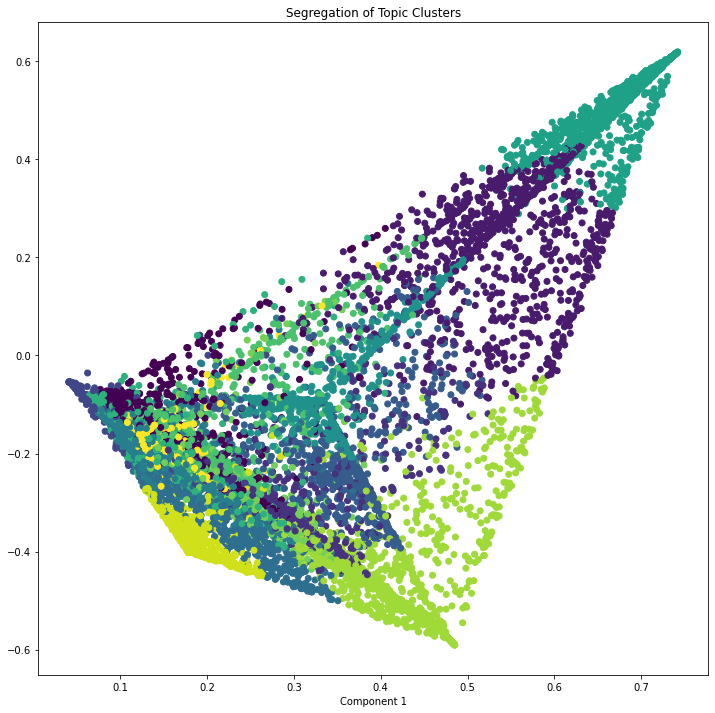

In [61]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## How to get similar documents for any given piece of text?

In [63]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


In [64]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['say', 'write', 'people', 'think', 'know', 'believe', 'make', 'line', 'christian', 'thing', 'just', 'article', 'subject', 'question', 'good']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]]

 Organization: Arizona State University From: Subject: Re: Celebrate Liberty! 1993 Lines: 5 Narrative, narrative, narrative. . . C.B. 
